# Detecting and Reacting to Spikes

The Loop API allows you easily and quickly react to action potentials (spikes).

This toy example loops 1000 times per second for 5 seconds, and stimulates any electrode where a spike is detected:

In [2]:
import cl

with cl.open() as neurons:
    for tick in neurons.loop(ticks_per_second=1000, stop_after_seconds=5):
        for spike in tick.analysis.spikes:
            neurons.stim(spike.channel, 1)

Each iteration makes detected action potentials and other data available via the tick object. This makes it easy to embody your lab-grown brain cells within a closed loop simulation:

In [ ]:
import cl

with cl.open() as neurons:
    
    # TODO: Initialise a simulated environment

    # Now run the closed loop
    for tick in neurons.loop(ticks_per_second=100):
 
        # TODO: Use tick.analysis.spikes to update the simulated environment

        # TODO: Break from loop if simulation is complete
            
        # TODO: Schedule electrode stimulation based on the new simualtion state

## Spike Objects

A `Spike` object is created for each spike detected by the system, and these are placed in a list at `tick.analysis.spikes`. Spike objects expose the following properties:

| Property | Data |
|-|-|
| `channel` | Which channel the spike was detected on |
| `timestamp` | Timestamp of the sample that triggered the detection of the spike |
| `samples` | Numpy array of 75 floating point µV sample values around timestamp |

Note that `samples` provides 1ms of sample values before, and 2ms **from** the moment of detection. As it is common for a loop body to process a detected spike within 2ms of it occuring, the `samples` data is loaded only on request. Be aware that accessing `spike.samples` before 2ms has passed will block until the requested data is available, i.e. your code could wait for up to 2ms.

Sample values are provided in floating point µV, and have been offset by the rolling mean sample value of the channel to centre the waveform around zero.

In practice, spike sample data is rarely needed at runtime and is better analysed from a recording, or live visualised from the built-in `cl_spikes` data stream.

This example waits for some spikes, then prints and plots the largest one:

Spike detected on channel 2 at timestamp 49686432.

75 Spike µV values (25 before + 50 from):

[ -0.19  -0.78  -1.56   4.68   2.14   4.09   7.02  -1.17   0.78  -0.19
   2.73   2.34   4.09   4.09   0.78  -2.53   4.48   3.12   2.34   3.51
   2.34  -0.19   2.92   3.9    3.9   14.62  -0.39  -0.78   2.73  -1.17
   4.09  -0.78   3.9   -3.12  -0.19   4.09  -8.97  -0.19   2.92  -0.78
   4.48   3.9  -10.72  -0.78   1.95  -2.34   3.51  -2.73   0.19   2.14
   3.7    3.9   -1.75   3.7    3.9    1.95   3.12  -2.53   2.14   2.34
   0.19   1.37  -2.73  -3.31  -4.09  -6.43  -3.31  -0.19   0.     3.9
   7.02   0.19   2.34  -3.9   -2.34]


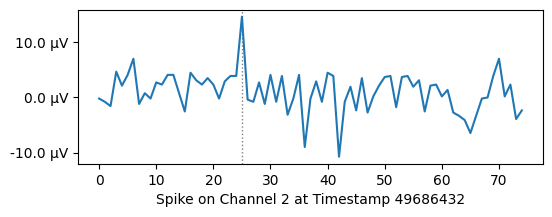

In [3]:
import cl
import numpy as np

from cl.util import plot_spike

with cl.open() as neurons:
    for tick in neurons.loop(ticks_per_second=1):
        spike = \
            max(
                tick.analysis.spikes,
                key=lambda spike: max(spike.samples) - min(spike.samples),
                default=None
                )
        if spike is None:
            continue

        print(f"Spike detected on channel {spike.channel} at "
              f"timestamp {spike.timestamp}.\n")

        print("75 Spike µV values (25 before + 50 from):\n")
        
        # 
        np.set_printoptions(precision=2, suppress=True)
        print(spike.samples)

        plot_spike(spike)
        break


# Timing Accuracy

To demonstrate the accuracy of CL API loop timing, this example runs at 1000 Hz and measures the intervals between loop ticks:

In [5]:
import cl
import time
import numpy as np

RUN_FOR_SECONDS  = 30
TICKS_PER_SECOND = 1000
RUN_FOR_TICKS    = RUN_FOR_SECONDS * TICKS_PER_SECOND
PERCENTILES      = [0.001, 0.01, 0.1, 1, 99, 99.9, 99.99, 99.999]

def loop_timing_test():    
    """ Measure loop timing accuracy when using the CL Loop API. """
    
    loop_times_ns = np.empty(RUN_FOR_TICKS, dtype=int)
    spike_count   = 0

    with cl.open() as neurons:
        
        # Execute a loop that periodically returns spikes,
        # stims, and raw electrode data
        for tick in neurons.loop(
                        TICKS_PER_SECOND,
                        stop_after_ticks=RUN_FOR_TICKS,
                        ignore_jitter=True
                        ):
            
            # Capture the time that this loop iteration executes
            loop_times_ns[tick.iteration] = time.monotonic_ns()
            
            # Track the total number of spikes detected
            spike_count += len(tick.analysis.spikes)    
    
    # The loop is complete.
    # Now, report on loop interval times.
    
    intervals_us = np.diff(loop_times_ns) / 1000
    mean_us      = np.mean(intervals_us)
    min_us       = np.min(intervals_us)
    max_us       = np.max(intervals_us)
    percentiles  = \
        [(p, np.percentile(intervals_us, p)) for p in PERCENTILES]

    print(f"Ran WITH CL API for {RUN_FOR_SECONDS} seconds "
          f"at {TICKS_PER_SECOND} ticks per second "
          f"and {spike_count / RUN_FOR_SECONDS:.3f} spikes per second.")

    print(f"\nMean interval: {mean_us:.3f} µs, "
          f"(min: {min_us:.3f} µs, max: {max_us:.3f} µs)\n")

    print("Percentiles:\n")
    for percentile, value in percentiles:
        print(f"{percentile:>6.3f}: {value:>4.3f} µs")

loop_timing_test()

Ran WITH CL API for 30 seconds at 1000 ticks per second and 376.200 spikes per second.

Mean interval: 1000.021 µs, (min: 934.620 µs, max: 1067.933 µs)

Percentiles:

 0.001: 937.221 µs
 0.010: 973.609 µs
 0.100: 996.752 µs
 1.000: 998.252 µs
99.000: 1001.942 µs
99.900: 1003.651 µs
99.990: 1027.414 µs
99.999: 1064.918 µs


The timing interval accuracy is slightly affected by the level of spike activity, as a Python object is created for each detected spike. When detecting hundreds of spikes per second, you can generally expect the interval to remain within about 40µs of target at tick rates of 25-12500 ticks per second. At thousands of spikes per second, a tick rate of 100 or higher may be needed to remain within 40µs of target.

Normally, a python process cannot achieve reliable timings without complex system administration work. When using the CL API on a Cortical Labs device, this is handled for you automatically whenever you have taken control of the device by calling `cl.open()`.

The following example demonstrates that loop interval accuracy **without** using the CL API is significantly worse, at times drifting by several milliseconds:

In [6]:
import time
import numpy as np
import gc

#
# Measure loop timing accuracy when using NOT the CL API.
#
# Spoiler: it's not good
#

RUN_FOR_SECONDS  = 30
TICKS_PER_SECOND = 1000
INTERVAL_NS      = 1e9 / TICKS_PER_SECOND
RUN_FOR_TICKS    = RUN_FOR_SECONDS * TICKS_PER_SECOND
PERCENTILES      = [0.001, 0.01, 0.1, 1, 99, 99.9, 99.99, 99.999]

def loop_timing_test():
    """ Measure loop timing accuracy when using a hot loop. """

    loop_times_ns = np.empty(RUN_FOR_TICKS, dtype=int)    
    next_tick_ns  = time.monotonic_ns() + INTERVAL_NS

    for i in range(RUN_FOR_TICKS):
        
        # Hot-loop until it is time for the next tick.
        # Sleeping would be an even worse result.
        while time.monotonic_ns() < next_tick_ns:
            pass
        
        # Capture the time
        loop_times_ns[i] = time.monotonic_ns()
        
        # Prepare the next deadline
        next_tick_ns += INTERVAL_NS    
    
    # The loop is complete.
    # Now, report on loop interval times.
    
    intervals_us = np.diff(loop_times_ns) / 1000
    mean_us      = np.mean(intervals_us)
    min_us       = np.min(intervals_us)
    max_us       = np.max(intervals_us)
    percentiles  = \
        [(p, np.percentile(intervals_us, p)) for p in PERCENTILES]

    print(f"Ran for {RUN_FOR_SECONDS} seconds, "
          f"at {TICKS_PER_SECOND} ticks per second")

    print(f"\nMean interval: {mean_us:.3f} µs, "
          f"(min: {min_us:.3f} µs, max: {max_us:.3f} µs)\n")

    print("Percentiles:\n")
    for percentile, value in percentiles:
        print(f"{percentile:>6.3f}: {value:>4.3f} µs")

try:
    # Stop garbage collection from interfering with our test
    gc.disable()
    loop_timing_test()
        
finally:
    gc.enable()

Ran for 30 seconds, at 1000 ticks per second

Mean interval: 1000.000 µs, (min: 5.600 µs, max: 2349.219 µs)

Percentiles:

 0.001: 83.189 µs
 0.010: 391.461 µs
 0.100: 891.318 µs
 1.000: 999.210 µs
99.000: 1000.790 µs
99.900: 1106.705 µs
99.990: 1608.440 µs
99.999: 2165.240 µs


While significant effort has been made to provide accurate timing when using the CL API, guarantees cannot be provided. For this reason among others, the Loop API will automatically raise an exception in cases where the loop is not executing fast enough. See the next section for details.



## Loop Timing Stability and Jitter

It is often important to your loop design that your code executes within a controlled amount of time from events occuring on the MEA. Delays in your loop body code could cause processing of subsequent ticks to progressively fall behind. In designs where stimulation is adjusted immediately in response to simulation changes, the result is an inconsistent latency from spike-to-stim, which impacts the consistency of the presentation of information to the cells.

To avoid this issue, the Loop API raises an error by default when the code in your loop body has taken too long to execute. This provides a more consistent latency between spike activity and the resulting stimulation. The following example illustrates this protection:

In [7]:
import cl
import time

#
# Intentionally trigger a jitter error.
#

with cl.open() as neurons:
    for tick in neurons.loop(ticks_per_second=1000):
        # Our loop body has 1 second / 1000 to execute
        # (minus Loop API overheads). Therefore we can
        # trigger the jitter protection by waiting for
        # at least 1ms.
        time.sleep(1 / 1000)

TimeoutError: Loop fell behind by 1 frame (40.0 µs) when entering the 2nd
iteration. Jitter tolerance is currently set to 0 frames. Ideally - optimise
the worst-case performance of your loop body. You may also adjust the jitter
tolerance via jitter_tolerance_frames=1, or ignore jitter entirely via
ignore_jitter=True.

---
It is possible to allow a specific amount of jitter by passing `jitter_tolerance_frames=x` to `neurons.loop()`, where `x` is the number of additional frames a loop body can execute for without raising a TimeoutError. Further, `ignore_jitter=True` will disable the jitter check entirely.

However, any additional time taken needs to be 'paid back' by other iterations taking less than the full amount of time. Otherwise the cumulative delay builds over time and eventually exeeds the live read buffer size of about 5 seconds:

In [10]:
import cl
import time

from cl.util import ordinal

TICKS_PER_SECOND=100

with cl.open() as neurons:
    try:
        for tick in neurons.loop(TICKS_PER_SECOND, ignore_jitter=True):
            # Fall behind by taking at least double the allowed time
            time.sleep(1 / TICKS_PER_SECOND * 2)
    except:
        now               = neurons.timestamp()
        frames_per_second = neurons.get_frames_per_second()
        behind_seconds    = (now - tick.timestamp) / frames_per_second
        print(
            f"Loop failed on {ordinal(tick.iteration + 1)} iteration "
            f"after falling {behind_seconds} seconds behind.")

Loop failed on 510th iteration after falling 5.13976 seconds behind.


## Ignoring Jitter

It is generally recommended that jitter tolerance be left at the default of zero frames, or failing that, allow only a small amount of jitter (remember that each frame is 40µs). Designs that work with the default jitter tolerance will work more reliably over longer periods of time.

However, there are exceptions. For example, you might want to process live spikes on another machine on the network. If the goal is to react to spikes as quickly as possible, it is desirable to run the loop at its fastest speed: 25000 ticks per second, 40µs per tick. Accounting for loop overheads, this is not enough time to assemble a UDP payload and send it.

The answer in this case is to ignore jitter. This lets the loop take as long as it needs to send the packet, and then quickly catches up between spikes. The following example sends a UDP packet for each tick containing spikes.

Before running it, you can open the [Appendix A. UDP Spike Receiver](CL-01A.%20Detecting%20and%20Reacting%20to%20Spikes.%20Appendix%20A.%20UDP%20Spike%20Receiver.ipynb) notebook in another window to watch the spike information arriving.

In [ ]:
import socket
import struct
import cl

from cl.util import Benchmark

# We'll UDP send packets to port 12345 on localhost.
PEER = ("127.0.0.1", 12345)

udp_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

with cl.open() as neurons:
    for tick in neurons.loop(
                    ticks_per_second=25000,
                    ignore_jitter=True,
                    stop_after_seconds=10):
        
        spikes = tick.analysis.spikes
        if spikes:
            
            # Create and send a binary payload containing
            # the spike timestamps and channels.
            
            first_spike = spikes[0]
            payload = struct.pack('<QB', first_spike.timestamp, first_spike.channel)
            
            if len(spikes) > 1:
                # Multiple spikes at the same timestamp, we add an extra byte for
                # each channel. A bitmask would be more efficient but less clear.
                payload = bytearray(payload)
                payload.extend([spike.channel for spike in spikes[1:]])
                
            udp_socket.sendto(payload, PEER)


## Next

[Recording](CL-02.%20Recording.ipynb)